In [72]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

In [73]:
IMAGE_SIZE = (320, 320)
BATCH_SIZE = 32
train_dir = "/Users/drip/Desktop/shape-robot/data/train"
val_dir = "/Users/drip/Desktop/shape-robot/data/val"
num_classes = 3

In [74]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=20,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [75]:
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False      # Keep order for confusion matrix
)

Found 1000 images belonging to 3 classes.
Found 121 images belonging to 3 classes.


In [76]:
import json, os

print("Saving to:", os.path.abspath("models/class_indices.json"))

os.makedirs("models", exist_ok=True)

with open("models/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)

print("DONE")

Saving to: /Users/drip/Desktop/shape-robot/notebooks/models/class_indices.json
DONE


In [77]:
train_gen.class_indices


{'circle': 0, 'square': 1, 'triangle': 2}

In [78]:
base_model = MobileNetV2(
    input_shape=(*IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/ipykernel_20031/3669249077.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [79]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 391ms/step - accuracy: 0.7390 - loss: 0.7090 - val_accuracy: 0.8430 - val_loss: 0.4981 - learning_rate: 1.0000e-04
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 364ms/step - accuracy: 0.8620 - loss: 0.4078 - val_accuracy: 0.8926 - val_loss: 0.3334 - learning_rate: 1.0000e-04
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.8980 - loss: 0.3161 - val_accuracy: 0.8760 - val_loss: 0.3005 - learning_rate: 1.0000e-04
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 404ms/step - accuracy: 0.9180 - loss: 0.2585 - val_accuracy: 0.9091 - val_loss: 0.2360 - learning_rate: 1.0000e-04
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 378ms/step - accuracy: 0.9430 - loss: 0.2091 - val_accuracy: 0.9339 - val_loss: 0.2345 - learning_rate: 1.0000e-04
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 390ms/step - accuracy: 0.9210 - loss: 0.2062 - val_accuracy: 0.9256 - val_loss: 0.1817 - learning_rate: 1.0000e-04
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 426ms/step - acc

In [80]:
for layer in base_model.layers[-80:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 675ms/step - accuracy: 0.6510 - loss: 0.8551 - val_accuracy: 0.9587 - val_loss: 0.1376 - learning_rate: 1.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 649ms/step - accuracy: 0.7990 - loss: 0.5067 - val_accuracy: 0.9421 - val_loss: 0.1366 - learning_rate: 1.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 671ms/step - accuracy: 0.8470 - loss: 0.3830 - val_accuracy: 0.9256 - val_loss: 0.1398 - learning_rate: 1.0000e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 662ms/step - accuracy: 0.8580 - loss: 0.3722 - val_accuracy: 0.9504 - val_loss: 0.1325 - learning_rate: 1.0000e-05
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 679ms/step - accuracy: 0.8800 - loss: 0.3352 - val_accuracy: 0.9421 - val_loss: 0.1337 - learning_rate: 1.0000e-05
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 683ms/step - accuracy: 0.8940 - loss: 0.3039 - val_accuracy: 0.9421 - val_loss: 0.1298 - learning_rate: 1.0000e-05
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step - acc

In [81]:
val_loss, val_acc = model.evaluate(val_gen)
print("Validation accuracy:", val_acc)

os.makedirs("models", exist_ok=True)
model.save("models/shape_mobilenet.h5")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.9421 - loss: 0.1206


Validation accuracy: 0.942148745059967


In [82]:
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 694ms/step - accuracy: 0.9330 - loss: 0.1947 - val_accuracy: 0.9587 - val_loss: 0.1270 - learning_rate: 1.0000e-05
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 696ms/step - accuracy: 0.9320 - loss: 0.2026 - val_accuracy: 0.9256 - val_loss: 0.1444 - learning_rate: 1.0000e-05
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.9270 - loss: 0.1956
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 702ms/step - accuracy: 0.9360 - loss: 0.1877 - val_accuracy: 0.9339 - val_loss: 0.1351 - learning_rate: 1.0000e-05
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 676ms/step - accuracy: 0.9460 - loss: 0.1658 - val_accuracy: 0.9339 - val_loss: 0.1298 - learning_rate: 2.0000e-06
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 654ms/step - accuracy: 0.9540 - loss: 0.1454 - val_accuracy: 0.9339 - val_loss: 0.1274 - learning_rate: 2.0000e-06


In [83]:
# Unfreeze last 40 layers for fine-tuning
for layer in base_model.layers[-80:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 666ms/step - accuracy: 0.9290 - loss: 0.2110 - val_accuracy: 0.9504 - val_loss: 0.1124 - learning_rate: 1.0000e-05
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 667ms/step - accuracy: 0.9340 - loss: 0.2060 - val_accuracy: 0.9587 - val_loss: 0.1062 - learning_rate: 1.0000e-05
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 655ms/step - accuracy: 0.9330 - loss: 0.1851 - val_accuracy: 0.9669 - val_loss: 0.1043 - learning_rate: 1.0000e-05
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 627ms/step - accuracy: 0.9470 - loss: 0.1526 - val_accuracy: 0.9752 - val_loss: 0.1091 - learning_rate: 1.0000e-05
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 628ms/step - accuracy: 0.9440 - loss: 0.1683 - val_accuracy: 0.9669 - val_loss: 0.1013 - learning_rate: 1.0000e-05
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - accuracy: 0.9490 - loss: 0.1371 - val_accuracy: 0.9752 - val_loss: 0.0868 - learning_rate: 1.0000e-05
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - acc

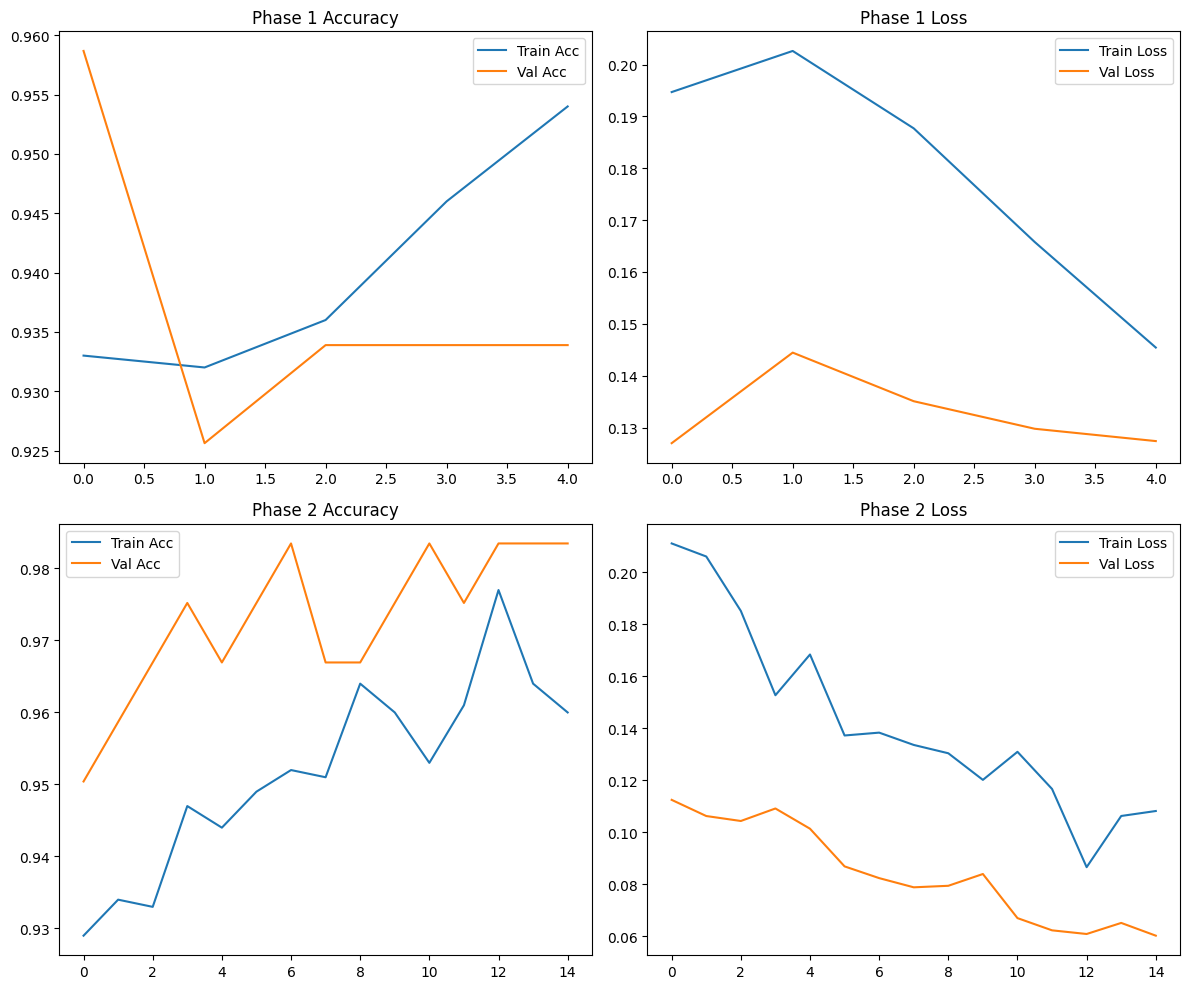

In [84]:
import matplotlib.pyplot as plt

acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs1 = range(len(acc1))
epochs2 = range(len(acc2))

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs1, acc1, label='Train Acc')
plt.plot(epochs1, val_acc1, label='Val Acc')
plt.title('Phase 1 Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs1, loss1, label='Train Loss')
plt.plot(epochs1, val_loss1, label='Val Loss')
plt.title('Phase 1 Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs2, acc2, label='Train Acc')
plt.plot(epochs2, val_acc2, label='Val Acc')
plt.title('Phase 2 Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs2, loss2, label='Train Loss')
plt.plot(epochs2, val_loss2, label='Val Loss')
plt.title('Phase 2 Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [85]:
model.save("/Users/drip/Desktop/shape-robot/models/shape_mobilenet.h5")

In [86]:
# Convert to TFLite
import tensorflow as tf

model = tf.keras.models.load_model("/Users/drip/Desktop/shape-robot/models/shape_mobilenet.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/Users/drip/Desktop/shape-robot/models/shape_mobilenet.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24/assets


INFO:tensorflow:Assets written to: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24/assets


Saved artifact at '/var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  15267027408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546698896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546712144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15267026832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14485192144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546712912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546711184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546710992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546710800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546711760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  145467113

W0000 00:00:1765117420.914612 230951823 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765117420.914623 230951823 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-07 21:23:40.914732: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24
2025-12-07 21:23:40.920018: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-07 21:23:40.920024: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24
2025-12-07 21:23:40.985900: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-07 21:23:41.334599: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmpzeljnw24
2025-12-07 21:23:41.432889: I tensorflow/cc/saved_model/loader

In [87]:
import json

with open("/Users/drip/Desktop/shape-robot/models/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)

In [88]:
# Unfreeze last 40 layers of MobileNetV2 for fine-tuning
for layer in base_model.layers[-40:]:
    layer.trainable = True

In [89]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [90]:
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 663ms/step - accuracy: 0.9710 - loss: 0.1045 - val_accuracy: 0.9669 - val_loss: 0.0613 - learning_rate: 1.0000e-05
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 672ms/step - accuracy: 0.9650 - loss: 0.1035 - val_accuracy: 0.9669 - val_loss: 0.0715 - learning_rate: 1.0000e-05
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.9595 - loss: 0.1226
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 639ms/step - accuracy: 0.9610 - loss: 0.1129 - val_accuracy: 0.9752 - val_loss: 0.0611 - learning_rate: 1.0000e-05
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 623ms/step - accuracy: 0.9720 - loss: 0.0908 - val_accuracy: 0.9752 - val_loss: 0.0607 - learning_rate: 2.0000e-06
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 640ms/step - accuracy: 0.9690 - loss: 0.0877 - val_accuracy: 0.9752 - val_loss: 0.0608 - learning_rate: 2.0000e-06


In [91]:
model.save("/Users/drip/Desktop/shape-robot/models/shape_mobilenet.h5")

In [92]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/Users/drip/Desktop/shape-robot/models/shape_mobilenet.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8/assets


INFO:tensorflow:Assets written to: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8/assets


Saved artifact at '/var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  15267027408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546698896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546712144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15267026832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14485192144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546712912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546711184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546710992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546710800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14546711760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  145467113

W0000 00:00:1765117535.443521 230951823 tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
W0000 00:00:1765117535.443532 230951823 tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-12-07 21:25:35.443638: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8
2025-12-07 21:25:35.448976: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-07 21:25:35.448982: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8
2025-12-07 21:25:35.509750: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-07 21:25:35.888268: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folders/ds/mnrvfp_j6cvc15p62cqgf1dr0000gn/T/tmphm9bltm8
2025-12-07 21:25:35.998451: I tensorflow/cc/saved_model/loader

In [93]:
import json
with open("/Users/drip/Desktop/shape-robot/models/class_indices.json", "w") as f:
    json.dump(train_gen.class_indices, f)

In [94]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [95]:
pred_probs = model.predict(val_gen)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = val_gen.classes

cm = confusion_matrix(true_labels, pred_labels)

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x30b307740> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 389ms/step


In [96]:
class_names = list(train_gen.class_indices.keys())
print("Class names in order:", class_names)

Class names in order: ['circle', 'square', 'triangle']


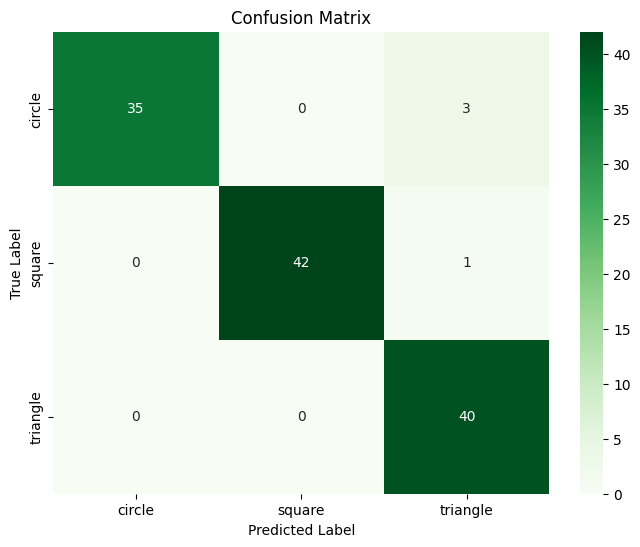

In [97]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()